In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

In [15]:
df_train = pd.read_csv('workingfolder\df_train.csv')
df_syn = pd.read_csv('workingfolder\synthetic.csv')
df_test = pd.read_csv('workingfolder\df_val.csv')

In [16]:
X_train = df_train.drop('income', axis = 1)
y_train = df_train['income']

X_syn = df_syn.drop('income', axis = 1)
y_syn = df_syn['income']

X_test = df_test.drop('income', axis = 1)
y_test = df_test['income']

In [17]:
# define categorical and numerical transformers
categorical_transformer = Pipeline(steps=[
    # ('SimpleImputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop=None))
])

numerical_transformer = Pipeline(steps=[
    # ('knnImputer', KNNImputer(n_neighbors=3, weights="uniform")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, make_column_selector(dtype_include="object")),
    ('numerical', numerical_transformer, make_column_selector(dtype_include= "number"))
])

X_train_processed = preprocessor.fit_transform(X_train)
print(f"Shape of X_train_processed after preprocessing: {X_train_processed.shape}")

X_test_processed = preprocessor.transform(X_test)
print(f"Shape of X_test_processed after preprocessing: {X_test_processed.shape}")

LE = LabelEncoder()
y_train_processed = LE.fit_transform(y_train)
print(f"Shape of y_train_processed after preprocessing: {y_train_processed.shape}")

y_test_processed = LE.transform(y_test)
print(f"Shape of y_test_processed after preprocessing: {y_test_processed.shape}")

Shape of X_train_processed after preprocessing: (37112, 92)
Shape of X_test_processed after preprocessing: (9279, 92)
Shape of y_train_processed after preprocessing: (37112,)
Shape of y_test_processed after preprocessing: (9279,)


In [18]:
rfc_real = RandomForestClassifier(n_estimators= 500, 
                                  min_samples_split= 5, 
                                  min_samples_leaf= 4,
                                  max_features= 'sqrt', 
                                  max_depth= None, 
                                  bootstrap= True,
                                  class_weight='balanced')
rfc_real.fit(X_train_processed, y_train_processed)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500)

In [19]:
def performance_metrics(model, X, y):

    y_pred = model.predict(X)

    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(data=cm,
                        index=['True Negative: 0', 'True Positive: 1'],
                        columns=['Pred Negative: 0', 'Pred Positive: 1'])
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')

    print("\n" "#=====#=====#===== Classification Report =====#=====#=====#")
    print(classification_report(y, y_pred))

def plot_evaluation_curves(model, X_train, X_test, y_train, y_test):
    performance_metrics = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for dataset, X, y in [('train', X_train, y_train), ('test', X_test, y_test)]:

        #=====#=====#=====#=====#=====
        # Compute metrics: Accuracy, F1, ROC AUC, Average Precision (AP)
        #=====#=====#=====#=====#=====
        performance_metrics[dataset] = {}

        y_pred = model.predict(X)
        y_pred_prob = model.predict_proba(X)[:, 1]

        # Accuracy
        accuracy = accuracy_score(y, y_pred)
        performance_metrics[dataset]['Accuracy'] = accuracy

        # F1
        f1 = f1_score(y, y_pred)
        performance_metrics[dataset]['F1'] = f1

        # ROC AUC
        roc_auc = roc_auc_score(y, y_pred_prob)
        performance_metrics[dataset]['ROC_AUC'] = roc_auc

        # Average Precision (AP)
        average_precision = average_precision_score(y, y_pred_prob)
        performance_metrics[dataset]['Average_Precision'] = average_precision

        #=====#=====#=====#=====#=====
        # Plot curves: F1 score, ROC, PRC
        #=====#=====#=====#=====#=====
        color = 'blue' if dataset == 'train' else 'orange'

        # F1 score
        thresholds = np.linspace(start=0, stop=1, num=100, endpoint=True)
        f1_scores = [f1_score(y, y_pred_prob >= th) for th in thresholds]
        max_f1_score_idx = np.argmax(f1_scores)

        ax = axs[0]
        ax.plot(thresholds, f1_scores, color=color, label=f"{dataset}, max={round(f1_scores[max_f1_score_idx], 2)} @ {round(thresholds[max_f1_score_idx], 2)}")
        # mark some thresholds
        for th in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            closest_threshold_idx = np.argmin(np.abs(thresholds-th))
            marker_color = 'red'
            ax.plot(thresholds[closest_threshold_idx], f1_scores[closest_threshold_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('decision function threshold')
        ax.set_ylabel('F1')
        ax.set_title('F1 Score')
        ax.legend(loc='lower center')


        # ROC
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f"{dataset}, ROC AUC={round(roc_auc, 2)}")
        # mark some thresholds
        for th in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            closest_threshold_idx = np.argmin(np.abs(thresholds-th))
            marker_color = 'red'
            ax.plot(fpr[closest_threshold_idx], tpr[closest_threshold_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
        ax.legend(loc='lower center')

        # PRC
        precision, recall, thresholds = precision_recall_curve(y, y_pred_prob)

        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f"{dataset}, Average Precision={round(average_precision, 2)}")
        # mark some thresholds
        for th in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            closest_threshold_idx = np.argmin(np.abs(thresholds-th))
            marker_color = 'red'
            ax.plot(recall[closest_threshold_idx], precision[closest_threshold_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision Recall Curve')
        ax.legend(loc='lower center')


    df_performance_metrics = pd.DataFrame(performance_metrics).round(2)
    display(df_performance_metrics)



#=====#=====#===== Classification Report =====#=====#=====#
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     29418
           1       0.76      0.53      0.63      7694

    accuracy                           0.87     37112
   macro avg       0.82      0.74      0.77     37112
weighted avg       0.86      0.87      0.86     37112



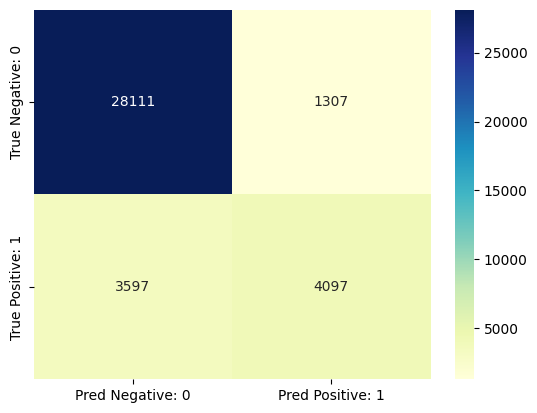

In [22]:
performance_metrics(rfc_real, X_train_processed, y_train_processed)


#=====#=====#===== Classification Report =====#=====#=====#
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7494
           1       0.70      0.50      0.59      1785

    accuracy                           0.86      9279
   macro avg       0.79      0.73      0.75      9279
weighted avg       0.85      0.86      0.85      9279



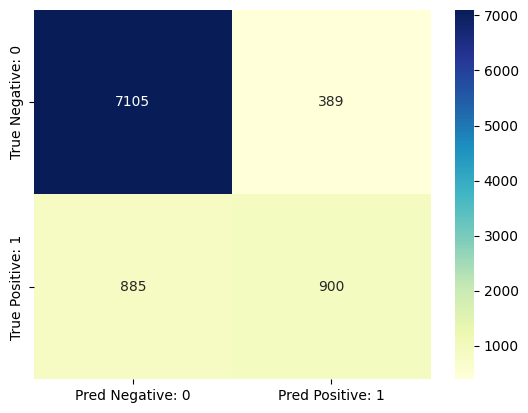

In [23]:
performance_metrics(rfc_real, X_test_processed, y_test_processed)

,train,test
Accuracy,0.87,0.86
F1,0.63,0.59
ROC_AUC,0.92,0.90
Average_Precision,0.76,0.70


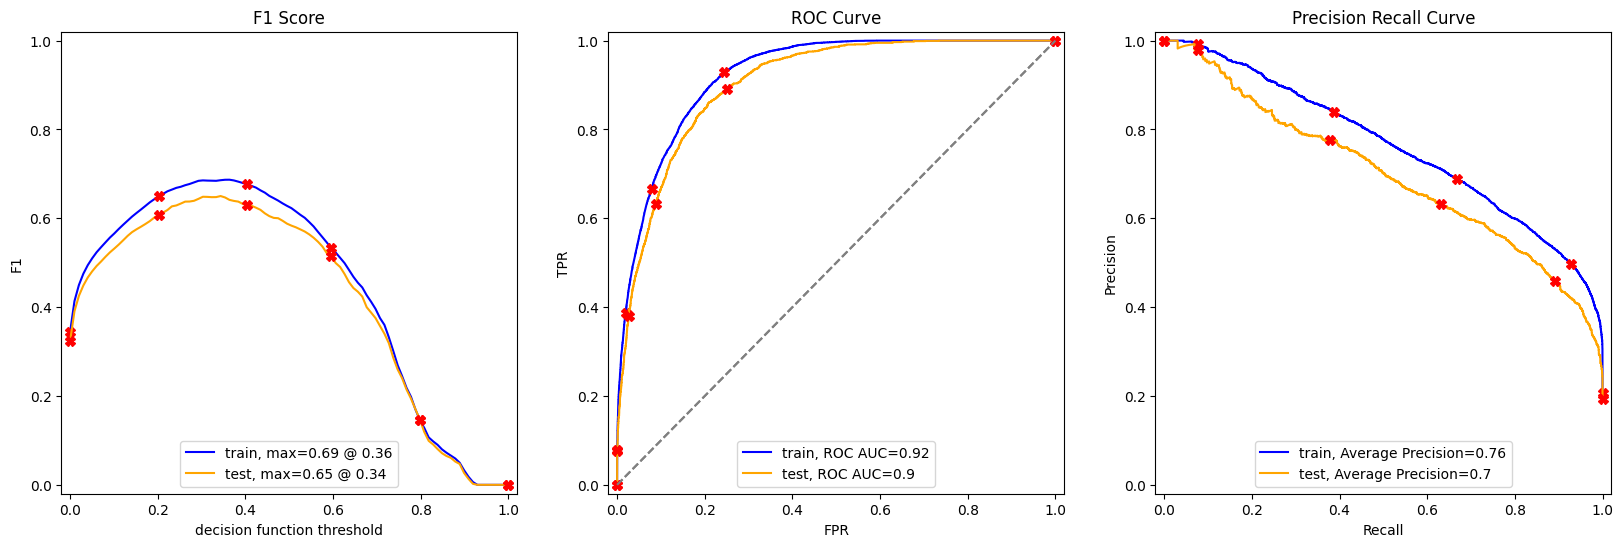

In [24]:
plot_evaluation_curves(rfc_real, X_train_processed, X_test_processed, y_train_processed, y_test_processed)

In [26]:
# define categorical and numerical transformers
categorical_transformer = Pipeline(steps=[
    # ('SimpleImputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop=None))
])

numerical_transformer = Pipeline(steps=[
    # ('knnImputer', KNNImputer(n_neighbors=3, weights="uniform")),
    ('scaler', StandardScaler())
])

preprocessor_syn = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, make_column_selector(dtype_include="object")),
    ('numerical', numerical_transformer, make_column_selector(dtype_include= "number"))
])

X_syn_processed = preprocessor_syn.fit_transform(X_syn)
print(f"Shape of X_syn_processed after preprocessing: {X_syn_processed.shape}")

X_test_syn_processed = preprocessor_syn.transform(X_test)
print(f"Shape of X_test_syn_processed after preprocessing: {X_test_syn_processed.shape}")

LE_syn = LabelEncoder()
y_syn_processed = LE_syn.fit_transform(y_syn)
print(f"Shape of y_syn_processed after preprocessing: {y_syn_processed.shape}")

y_syn_test_processed = LE.transform(y_test)
print(f"Shape of y_syn_test_processed after preprocessing: {y_syn_test_processed.shape}")

Shape of X_syn_processed after preprocessing: (37106, 92)
Shape of X_test_syn_processed after preprocessing: (9279, 92)
Shape of y_syn_processed after preprocessing: (37106,)
Shape of y_syn_test_processed after preprocessing: (9279,)


In [27]:
rfc_syn = RandomForestClassifier(n_estimators= 500, 
                                 min_samples_split= 5, 
                                 min_samples_leaf= 4, 
                                 max_features= 'sqrt', 
                                 max_depth= None, 
                                 bootstrap= True,
                                 class_weight='balanced')
rfc_syn.fit(X_syn_processed, y_syn_processed)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500)


#=====#=====#===== Classification Report =====#=====#=====#
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     29836
           1       0.75      0.44      0.56      7270

    accuracy                           0.86     37106
   macro avg       0.82      0.70      0.74     37106
weighted avg       0.85      0.86      0.85     37106



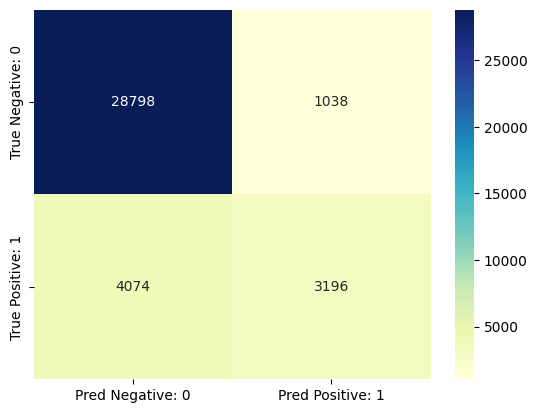

In [28]:
performance_metrics(rfc_syn, X_syn_processed, y_syn_processed)


#=====#=====#===== Classification Report =====#=====#=====#
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      7494
           1       0.64      0.38      0.47      1785

    accuracy                           0.84      9279
   macro avg       0.75      0.66      0.69      9279
weighted avg       0.82      0.84      0.82      9279



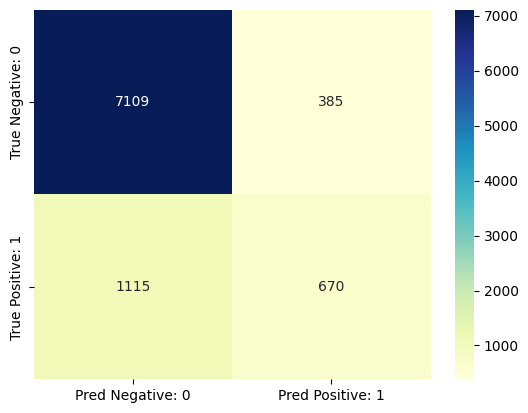

In [29]:
performance_metrics(rfc_syn, X_test_syn_processed, y_syn_test_processed)

,train,test
Accuracy,0.86,0.84
F1,0.56,0.47
ROC_AUC,0.92,0.85
Average_Precision,0.74,0.54


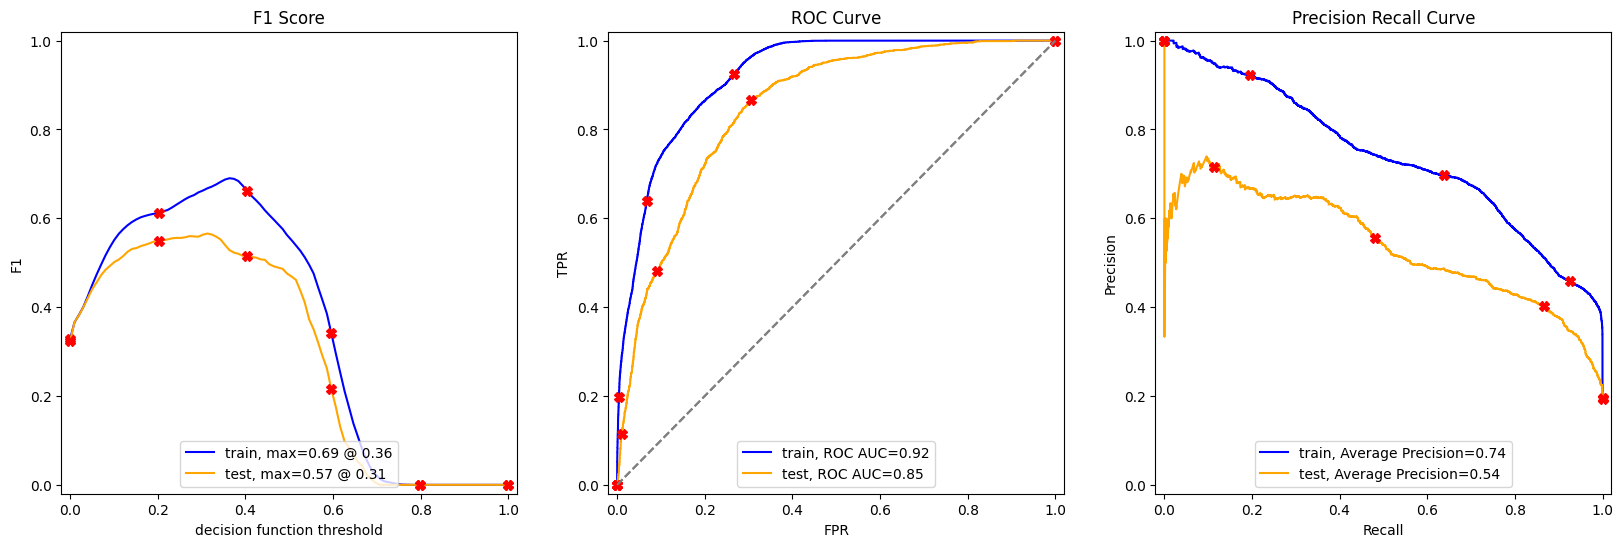

In [30]:
plot_evaluation_curves(rfc_syn, X_syn_processed, X_test_syn_processed, y_syn_processed, y_syn_test_processed)